# Arbitrage-Free IV Surface (SVI)

**Goal.** Fit raw-SVI per expiry, enforce **calendar no-arbitrage** via isotonic regression on variance-per-time, and visualize the resulting surface.

**What you’ll see**
- Per-expiry smile fits (market vs SVI)
- 2D surface (K × T) of implied vol
- ATM term structure and static-arb sanity checks
- Persisted `w_grid`, `k_grid`, `tenors` to `.npz` for reuse

**Dependencies**
- `svi_surface.py` in `src/` (or same folder)
- `black_scholes.py`
- Optional: `data.data_loader.fetch_current_chain` if `USE_MARKET=True`


In [1]:
# Imports & plotting style
import sys,os, math, numpy as np
import matplotlib.pyplot as plt



# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
plt.rcParams.update({
    "figure.figsize": (7.5, 5.0),
    "axes.grid": True,
    "grid.alpha": 0.35,
    "font.family": "Times New Roman",  # remove or change if you prefer
})
from src.black_scholes import black_scholes_price
from src.svi_surface import fit_svi_surface
from data.data_loader import fetch_stock_data, fetch_current_chain,compute_annualized_volatility,get_latest_price

## 1) Load data

Try live market chain (one ticker, multiple expiries). If unavailable, generate a synthetic but realistic chain (convex skew) so everything runs.


In [2]:
import math, numpy as np

# --- helpers ---
def invert_iv_call_mid(S, K, T, r, q, mid, tol=1e-8, iters=80):
    F = S * math.exp((r - q) * T)
    p = float(np.clip(mid,
                      max(0.0, math.exp(-r*T)*(F-K)),
                      S * math.exp(-q*T)))
    lo, hi = 1e-6, 5.0
    for _ in range(iters):
        m = 0.5*(lo+hi)
        if black_scholes_price(S, K, T, r, m, option_type="call") > p: hi = m
        else: lo = m
        if hi-lo < tol: break
    return 0.5*(lo+hi)

def clean_slice(df, S0, T, r, q):
    F = S0 * np.exp((r - q) * T)
    k = np.log(df["strike"].to_numpy(float) / F)
    iv = df["iv"].to_numpy(float)
    band = 0.35 if T < 0.03 else (0.5 if T < 0.15 else 0.7)
    m = (np.abs(k) <= band) & (iv > 1e-4) & (iv < 3.0)
    for col in ("volume","open_interest"):
        if col in df.columns: m &= (df[col].to_numpy()>0) | (df[col].isna().to_numpy())
    if m.sum() >= 12:
        lo, hi = np.quantile(iv[m], [0.05, 0.95])
        m &= (iv >= lo) & (iv <= hi)
    return k[m], iv[m]

def vega_weights(S, K, T, r, q, iv):
    F = S * np.exp((r - q) * T)
    sig = iv * np.sqrt(T)
    d1 = (np.log(F/K) + 0.5*sig*sig) / np.maximum(sig, 1e-12)
    return np.sqrt(T) * np.exp(-0.5*d1*d1)

# --- loader ---
def load_chains(USE_MARKET=True, ticker="AAPL"):
    chains, S0, r, q, source = {}, 100.0, 0.02, 0.00, "synthetic"
    if USE_MARKET:
        try:
            from data.data_loader import fetch_stock_data, fetch_current_chain
            stock = fetch_stock_data(ticker, start="2024-01-01")
            S0 = stock["Close"].iloc[-1].item()
            raw = fetch_current_chain(ticker).dropna().copy()
            raw["type"] = raw["type"].str.lower()
            calls = raw[raw["type"].eq("call")]
            exp_sorted = np.sort(calls["expiration"].unique())
            pick_idx = np.round(np.linspace(0, len(exp_sorted)-1, min(5, len(exp_sorted)))).astype(int)
            for exp in exp_sorted[pick_idx]:
                sl = calls[calls["expiration"]==exp].copy()
                T = max(1e-9, (np.datetime64(exp)-np.datetime64("today"))/np.timedelta64(1,"D"))/365.0
                if T <= 0 or sl.empty: continue
                sl = sl[(sl["mid"]>1e-4) & (sl["strike"]>1e-6)].sort_values("strike")
                K = sl["strike"].to_numpy(float); M = sl["mid"].to_numpy(float)
                ivs = np.array([invert_iv_call_mid(S0, float(k), T, r, q, float(p)) for k,p in zip(K,M)])
                sl["iv"] = ivs
                k_c, iv_c = clean_slice(sl, S0, T, r, q)
                F_T = S0 * np.exp((r - q) * T)
                K_c = (F_T * np.exp(k_c)).astype(float)
                USE_VEGA_RESAMPLE = True
                if USE_VEGA_RESAMPLE and K_c.size >= 15:
                    w = vega_weights(S0, K_c, T, r, q, iv_c); w = np.clip(w,1e-12,None); w /= w.sum()
                    rng = np.random.RandomState(123)
                    n = min(60, K_c.size)
                    idx = rng.choice(np.arange(K_c.size), size=n, replace=True, p=w)
                    K_fit, iv_fit = K_c[idx], iv_c[idx]
                else:
                    K_fit, iv_fit = K_c, iv_c
                if K_fit.size >= 10: chains[T] = {"K": K_fit, "iv": iv_fit}
            if chains: source = "market"
        except Exception as e:
            print(f"[INFO] Market path failed: {e}")

    if source == "synthetic":
        np.random.seed(7)
        tenors = np.array([0.08, 0.25, 0.50, 0.90])
        atm_targets = {0.08:0.35, 0.25:0.30, 0.50:0.26, 0.90:0.24}
        a0,b0,rho0,m0,s0 = 0.004, 0.22, -0.45, 0.0, 0.22
        for T in tenors:
            F_T = S0*np.exp((r-q)*T)
            K = np.linspace(70,130,41)
            k = np.log(K/F_T)
            w = a0 + b0*(rho0*(k-m0) + np.sqrt((k-m0)**2 + s0**2))
            w_atm = float(w[np.argmin(np.abs(k))])
            scale = (atm_targets[T]**2 * T) / max(w_atm, 1e-12)
            iv = np.sqrt(np.clip(scale*w, 1e-10, None)/T) + 0.001*np.random.randn(k.size)
            chains[T] = {"K": K, "iv": np.clip(iv, 0.05, 1.0)}

    print(f"[INFO] SOURCE: {source}")
    print("Expiries (years):", np.round(sorted(chains.keys()), 4).tolist())
    return chains, S0, r, q

# usage
chains_by_expiry, S0, r, q = load_chains(USE_MARKET=True, ticker="AAPL")
for T, d in sorted(chains_by_expiry.items()):
    print(f"T={T:.4f}  strikes={len(d['K'])}  IV[min,max]=[{d['iv'].min():.3f}, {d['iv'].max():.3f}]")


[*********************100%***********************]  1 of 1 completed


[INFO] SOURCE: market
Expiries (years): [0.0137, 0.1096, 0.4932, 0.9918, 2.3342]
T=0.0137  strikes=37  IV[min,max]=[0.252, 0.424]
T=0.1096  strikes=25  IV[min,max]=[0.257, 0.383]
T=0.4932  strikes=29  IV[min,max]=[0.239, 0.490]
T=0.9918  strikes=40  IV[min,max]=[0.239, 0.395]
T=2.3342  strikes=17  IV[min,max]=[0.256, 0.332]


## 2) Fit SVI per expiry and enforce calendar no-arb

This uses the `fit_svi_surface(...)` wrapper which:
1) fits **raw-SVI** per expiry, then  
2) applies isotonic regression on \(w/T\) across maturities on a fixed log-moneyness grid, and  
3) returns an `SVISurface` with `iv(k, T)` and `w(k, T)` interpolators.


In [3]:
surf = fit_svi_surface(chains_by_expiry, S0=S0, r=r, q=q, mode="iv")

# Persist for reuse in pricing/backtests
os.makedirs("artifacts", exist_ok=True)
np.savez("artifacts/svi_surface_latest.npz",
         tenors=surf.tenors, k_grid=surf.k_grid, w_grid=surf.w_grid)
print("Saved surface to artifacts/svi_surface_latest.npz")


Saved surface to artifacts/svi_surface_latest.npz


## 3) Smile slices: market IV vs SVI fit

For a couple of expiries, plot empirical IVs against the post-projection SVI smiles (no-arb).


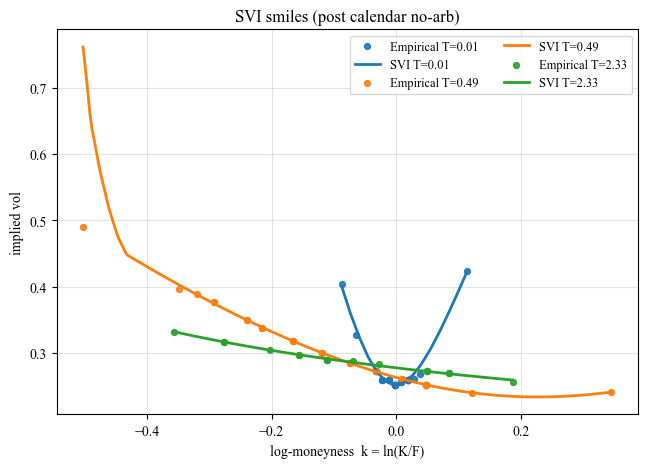

In [4]:
# pick up to 3 expiries across the span
Ts = sorted(chains_by_expiry.keys())
pick_idx = np.round(np.linspace(0, len(Ts)-1, min(3, len(Ts)))).astype(int)
pick_T = [Ts[i] for i in pick_idx]

tight_band_for_tinyT = 0.30

Ts = sorted(chains_by_expiry.keys())
pick_idx = np.round(np.linspace(0, len(Ts)-1, min(3, len(Ts)))).astype(int)
pick_T = [Ts[i] for i in pick_idx]
fig, ax = plt.subplots()
for T in pick_T:
    F_T = S0 * np.exp((r - q) * T)
    K = chains_by_expiry[T]["K"]
    iv_emp = chains_by_expiry[T]["iv"]
    k_emp = np.log(K / F_T)
    # empirical: scatter only
    ax.scatter(k_emp, iv_emp, s=18, alpha=0.9, label=f"Empirical T={T:.2f}")
    # model: smooth line on a sorted k-grid spanning the empirical support
    k_min, k_max = np.min(k_emp), np.max(k_emp)
    # optionally trim tiny tails for a cleaner view:
    # k_min, k_max = np.quantile(k_emp, [0.02, 0.98])
    k_line = np.linspace(k_min, k_max, 300)
    iv_fit = surf.iv(k_line, T)
    ax.plot(k_line, iv_fit, lw=2, label=f"SVI T={T:.2f}")

ax.set_xlabel("log-moneyness  k = ln(K/F)")
ax.set_ylabel("implied vol")
ax.set_title("SVI smiles (post calendar no-arb)")
ax.legend(ncol=2, fontsize=9)
ax.grid(True, alpha=0.35)
plt.show()


## 4) 2D IV surface (K × T)


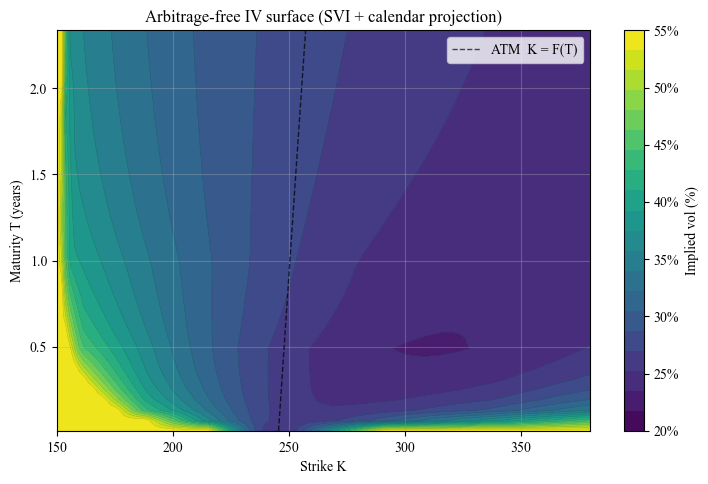

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import Normalize

# Build grids
Tgrid = np.linspace(min(surf.tenors), max(surf.tenors), 40)
Kmin = min(d["K"].min() for d in chains_by_expiry.values())
Kmax = max(d["K"].max() for d in chains_by_expiry.values())
Kgrid = np.linspace(Kmin, Kmax, 120)

# Evaluate IV on (K, T); also compute ATM ridge K = F(T)
IV = np.zeros((Tgrid.size, Kgrid.size))
ATM = np.zeros_like(Tgrid)
for i, T in enumerate(Tgrid):
    F_T = S0 * np.exp((r - q) * T)
    krow = np.log(Kgrid / F_T)
    IV[i] = surf.iv(krow, T)
    ATM[i] = F_T

# Handle NaNs/Infs and clip to display range
vmin, vmax = 0.20, 0.55   # show 20–55% only
IV = np.where(np.isfinite(IV), IV, np.nan)
IV_disp = np.clip(IV, vmin, vmax)  # saturate extremes so the colorbar stays in-range

# Shared normalization for both contourf and contour lines
norm = Normalize(vmin=vmin, vmax=vmax)
levels = np.linspace(vmin, vmax, 21)

fig, ax = plt.subplots(figsize=(8.6, 5.2))
cs = ax.contourf(Kgrid, Tgrid, IV_disp, levels=levels, norm=norm, extend='neither')
ax.contour(Kgrid, Tgrid, IV_disp, levels=levels, norm=norm, linewidths=0.4, colors="k", alpha=0.2)

# Colorbar in %
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label("Implied vol (%)")
cbar.set_ticks(np.linspace(vmin, vmax, 8))
cbar.set_ticklabels([f"{t*100:.0f}%" for t in np.linspace(vmin, vmax, 8)])

# ATM ridge
ax.plot(ATM, Tgrid, "--", color="k", linewidth=1, alpha=0.7, label="ATM  K = F(T)")
ax.legend(loc="upper right", frameon=True)

ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T (years)")
ax.set_title("Arbitrage-free IV surface (SVI + calendar projection)")
ax.grid(True, alpha=0.35)
plt.show()

## 5) ATM term structure and static-arb checks

- **ATM vol** at \(k=0\) across maturities  
- **Calendar no-arb** sanity: \(w/T\) should be non-decreasing in \(T\) for fixed \(k\).  
- **Butterfly convexity** sanity: numeric curvature in \(k\) ≥ 0 (on a grid).


In [6]:
# 1) ATM vol vs maturity (as %)
print("ATM term structure (post-projection):")
for T in sorted(chains_by_expiry.keys()):
    atm = surf.iv([0.0], T).item()
    print(f"  T={T:>5.2f}  ATM={atm*100:5.1f}%")

# 2) Calendar no-arbitrage: total variance w(k,T) must be non-decreasing in T
#    (Equivalent to call prices non-decreasing in maturity.)
ks_to_check = [-0.30, 0.00, 0.30]
print("\nCalendar no-arb on total variance w(k,T):")
for kval in ks_to_check:
    Ts = sorted(chains_by_expiry.keys())
    w_vals = np.array([(surf.iv([kval], T).item()**2) * T for T in Ts])
    diffs = np.diff(w_vals)
    ok = np.all(diffs >= -1e-6)
    status = "OK" if ok else "VIOLATION"
    print(f"  k={kval:+.2f}  w(T) monotone: {status}")
    assert ok, f"Calendar arbitrage detected at k={kval:+.2f}"

# 3) Butterfly (static) no-arb: convexity in k (numeric second derivative >= 0 on a grid)
print("\nButterfly convexity (numeric) across tenors:")
for T in sorted(chains_by_expiry.keys()):
    # evaluate on a reasonable k-line inside the fitted grid
    kline = np.linspace(surf.k_grid.min()+1e-3, surf.k_grid.max()-1e-3, 161)
    wline = (surf.iv(kline, T)**2) * T
    h = np.gradient(kline)
    wpp = (np.roll(wline, -1) - 2*wline + np.roll(wline, 1)) / ((0.5*(h + np.roll(h,1)))**2 + 1e-16)
    wpp = wpp[1:-1]  # drop edges
    ok = np.all(wpp >= -1e-6)
    status = "OK" if ok else "VIOLATION"
    print(f"  T={T:>5.2f}  convexity: {status}")
    assert ok, f"Negative curvature (butterfly arbitrage) at T={T:.3f}"

print("\nAll sanity checks passed.")


ATM term structure (post-projection):
  T= 0.01  ATM= 25.2%
  T= 0.11  ATM= 26.5%
  T= 0.49  ATM= 26.3%
  T= 0.99  ATM= 27.2%
  T= 2.33  ATM= 27.7%

Calendar no-arb on total variance w(k,T):
  k=-0.30  w(T) monotone: OK
  k=+0.00  w(T) monotone: OK
  k=+0.30  w(T) monotone: OK

Butterfly convexity (numeric) across tenors:
  T= 0.01  convexity: OK
  T= 0.11  convexity: OK
  T= 0.49  convexity: OK
  T= 0.99  convexity: OK
  T= 2.33  convexity: OK

All sanity checks passed.


## 6) Quick error snapshot (if empirical IVs provided)

Bucket MAE by moneyness for a selected expiry to sanity-check fit quality.


In [7]:
# Pick the median expiry
Tsel = float(surf.tenors[len(surf.tenors)//2])
F_sel = S0*np.exp((r-q)*Tsel)
K = chains_by_expiry[Tsel]["K"]
iv_emp = chains_by_expiry[Tsel]["iv"]
k = np.log(K/F_sel)
iv_fit = surf.iv(k, Tsel)

abs_err = np.abs(iv_fit - iv_emp)
bins = [-np.inf, -0.3, -0.1, 0.1, 0.3, np.inf]
labels = ["deep ITM", "ITM", "ATM", "OTM", "deep OTM"]
bucket = np.digitize(k, bins) - 1  # 0..4

mae_by_bucket = {labels[i]: float(abs_err[bucket==i].mean()) if np.any(bucket==i) else np.nan
                 for i in range(5)}
print("MAE by moneyness bucket at T={:.3f}:".format(Tsel))
for name, v in mae_by_bucket.items():
    print(f"  {name:>8}: {v:.5f}")


MAE by moneyness bucket at T=0.493:
  deep ITM: 0.09309
       ITM: 0.00085
       ATM: 0.00036
       OTM: 0.00085
  deep OTM: 0.00042


## 7) Reuse in pricing/backtests

Save/load the surface and query vol anywhere:


In [8]:
# Save already done; here is how to load later:
data = np.load("artifacts/svi_surface_latest.npz")
tenors, k_grid, w_grid = data["tenors"], data["k_grid"], data["w_grid"]

# Tiny helper to rebuild an SVISurface-like object for querying
class _SVISurfaceLite:
    def __init__(self, tenors, k_grid, w_grid):
        self.tenors = tenors.astype(float)
        self.k_grid = k_grid.astype(float)
        self.w_grid = w_grid.astype(float)

    def iv(self, k_array, T):
        from scipy.interpolate import interp1d
        k = np.asarray(k_array, dtype=float)
        # interp in k per tenor
        rows = []
        for m in range(self.tenors.size):
            fk = interp1d(self.k_grid, self.w_grid[m], kind="linear", fill_value="extrapolate")
            rows.append(fk(k))
        mat = np.vstack(rows)
        fT = interp1d(self.tenors, mat, axis=0, kind="linear", fill_value="extrapolate")
        w = fT(float(T))
        Tclip = max(T, 1e-8)
        return np.sqrt(np.maximum(w, 1e-12)/Tclip)

surf_lite = _SVISurfaceLite(tenors, k_grid, w_grid)
print("Reconstructed lite surface; sample ATM vol at first tenor:",
      surf_lite.iv(np.array([0.0]), float(tenors[0])).item())


Reconstructed lite surface; sample ATM vol at first tenor: 0.2520605910422095


In [ ]:
# map (S, K, T) -> k, then query vol from the surface
def iv_from_surface(surf_like, S, K, T, r=0.02, q=0.0):
    F = S * np.exp((r - q) * T)
    k = np.log(K / F)
    return surf_like.iv(np.array([k]), T).item()  

# example: price a call using the BS pricer + surface vol

S, K, T, r, q = 100.0, 105.0, float(surf_lite.tenors[0]), 0.02, 0.0
sigma = iv_from_surface(surf_lite, S, K, T, r, q)
price = black_scholes_price(S, K, T, r, sigma, option_type="call")
sigma, price


(0.2962491776811647, 0.1304680682708952)